In [1]:
import os
import sys
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['THEANO_FLAGS'] = 'device=cpu,compiledir_format="ipynb_cpu"'
sys.path.append(os.getcwd()+"/..")
import theano.tensor as T
import theano
import lasagne

from tasks import check
from lasagne import layers as L

from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import matplotlib.pyplot as plt
from skimage.io import imsave

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
from tqdm import tqdm

%matplotlib inline
from IPython.display import Image

import matplotlib.pyplot as plt
from lasagnekit.misc.plot_weights import tile_raster_images
import numpy as np
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
from helpers import salt_and_pepper
import lasagne
import pickle
from lasagne import layers

def load_gan_model(filename):
    import dcgan
    
    data = pickle.load(open(filename))
    gen = data['generator']
    discr = data['discriminator']
    return gen, discr

def sample(x):
    return (np.random.uniform(size=x.shape) <= x).astype(np.float32)

def floatX(x):
    return x.astype(np.float32)

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, max(len(inputs) - batchsize + 1, len(inputs)), batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def sigmoid(x):
    return 1./(1. + np.exp(-x))

from tools.brushstroke.common import to_grid_of_images, disp_grid
from tools.brushstroke.common import load_model, get_bias, get_scale
from lasagnekit.misc.draw_net import draw_to_file
from IPython.display import SVG

/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## load model

In [2]:
from lightjob.cli import load_db
db = load_db()
s = db.get_job_by_summary('8b4064243348c6285cfdad39c84fee88')['content']['model_summary']
filename = "../jobs/results/{}/model.pkl".format(s)

filename ='../training/test/model.pkl'

In [3]:
capsule, data, layers = load_model(filename)
c, w, h = layers['input'].shape[1:]

(None, 128, 8, 8)
(None, 128, 16, 16)
(None, 128, 32, 32)
(None, 1, 64, 64)
Loading data...


INFO:tasks:Loading data...


(None, 128, 8, 8)
(None, 128, 16, 16)
(None, 128, 32, 32)
(None, 1, 64, 64)
(None, 128, 8, 8)
(None, 128, 16, 16)
(None, 128, 32, 32)
(None, 1, 64, 64)
Loading the model...


INFO:tasks:Loading the model...


(None, 128, 8, 8)
(None, 128, 16, 16)
(None, 128, 32, 32)
(None, 1, 64, 64)
Compiling the model...


INFO:tasks:Compiling the model...


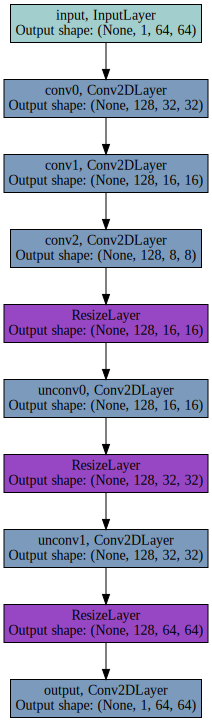

In [4]:
draw_to_file(L.get_all_layers(layers['output']), 'out.svg')
SVG('out.svg')

In [5]:
for l in layers:
    print(l)

input
conv0
conv1
conv2
unconv0
unconv1
output


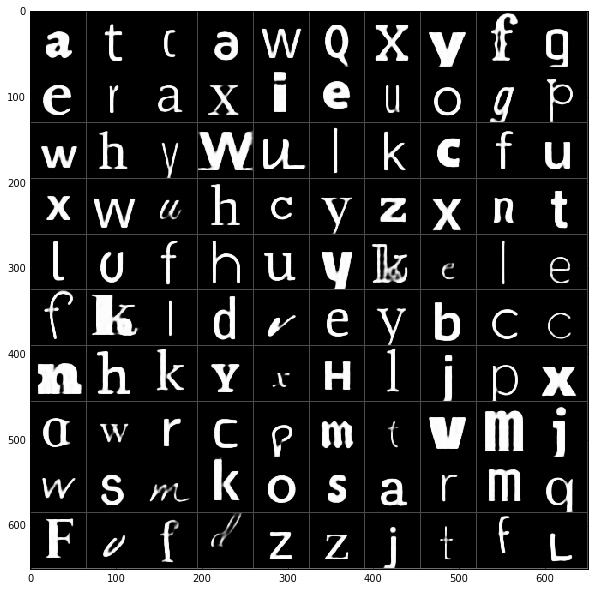

In [6]:
data.load()
X = data.X[0:100]
X = capsule.preprocess(X)
Xrec = capsule.reconstruct(X)
fig = plt.figure(figsize=(10,10))
plt.imshow(disp_grid(Xrec, border=1, bordercolor=(0.3,0.3,0.3)), interpolation='none')

## ProgramNeural network

In [ ]:
X_t = T.tensor4()
get_coords = theano.function([X_t], L.get_output(layers['coord_0_normalized'], X_t))
get_repr = theano.function([X_t], L.get_output(layers['repr_0_normalized'], X_t))

C = T.tensor3()
R = T.tensor3()
render = theano.function(
    [C, R],
    L.get_output(layers['output'], 
                 {layers['coord_0_normalized']: C, layers['repr_0_normalized']: R}, 
                 deterministic=True)
)

In [ ]:
feat_layers = [l for l in layers.keys() if 'normalized' in l]
get_feats = theano.function([X_t], [L.get_output(layers[l], X_t) for l in feat_layers])

In [ ]:
#get_coords_1 = theano.function([X_t], L.get_output(layers['coord_1_0_normalized'], X_t))
#get_rel_coords_1 = theano.function([X_t], L.get_output(layers['coord_5_0'], X_t))

In [ ]:
X = data.X[0:9]
X = capsule.preprocess(X)
coords = get_coords(X)
reprs = get_repr(X)

In [ ]:
reprs_ = reprs.copy()
coords_ = coords.copy()
coords_[:]=0.5
reprs_[:]=0
#coords_[:]=-10
#coords_[:,0]=0.5
#reprs_[:,0,0]=1

In [ ]:
Xrec = render(coords_, reprs_)
Xrec = Xrec
img = disp_grid(Xrec, border=1, bordercolor=(0.3,0,0))
imsave('out.png', img)
Image('out.png', width=400, height=400)

## Only come here To check vertebrate  convnets

In [ ]:
print(layers)
code_layers = ['sparse0', 'sparse1', 'sparse2', 'sparse3']
X_t = T.tensor4()
encode = theano.function(
    [X_t], 
    [L.get_output(layers[cc], X_t) for cc in code_layers]
)
code_t = [T.tensor4() for _ in code_layers]
decode = theano.function(
    code_t,
    L.get_output(layers['output'], {layers[name]: t for name, t in zip(code_layers, code_t)})
)

In [ ]:
X = data.X[0:100]
X=capsule.preprocess(X)

In [ ]:
C = encode(X)
Xrec = decode(*C)

In [ ]:
m = C[3][0][:, None, :, :]
fig = plt.figure(figsize=(10,10))
plt.imshow(disp_grid(m, border=1, bordercolor=(0.3, 0, 0)))

In [ ]:
C = list(encode(X))
cc = []#include these
for i in set(range(len(C))) - set(cc):
    C[i][:] = 0
C_zeros = [np.zeros_like(c) for c in C]
M = [3]#change these

for _ in range(1):
    for i in M:
        F = C[i].shape[1]
        W = C[i].shape[2]
        H = C[i].shape[3]
        N = min(C[i].shape[0], F)
        C[i][np.arange(N), 
             np.arange(N), 
             np.random.randint(0, W, size=N), 
             np.random.randint(0, H, size=N)
             #0,
             #0,
        ] = 20

"""
for i in M:
    for n in range(N):
        F = C[i].shape[1]
        W = C[i].shape[2]
        H = C[i].shape[3]
        C[i][n, np.arange(F), np.random.randint(0, H, size=F), np.random.randint(0, W, size=F)] = 10
"""

fig = plt.figure(figsize=(20, 20))
Xrec = decode(*C)
X_rec_zero = decode(*C_zeros)

res = Xrec# - X_rec_zero
recons = dispims_color(res.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=1, bordercolor=(0.5,0.5,0.5))
plt.imshow(recons)

In [ ]:
for i in range(len(C)):
    print(C[i].shape)

## viz features

In [ ]:
nbpixels = 28*28
for name, layer in layers.items():
    if hasattr(layer, "W"):
        W = layer.W.get_value()
        if len(W.shape)==2 and (W.shape[0] == nbpixels or W.shape[1] == nbpixels):
            nbpixels = c*w*h
            if W.shape[0] == nbpixels:
                W = W.T
            W = W.reshape((W.shape[0], c, w, h))
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[1] in (1, 3):
            W = W.transpose((0, 2, 3, 1))
            W = W * np.ones((1, 1, 1, 3))
        elif len(W.shape) == 4 and W.shape[0] in (1, 3):
            W = W.transpose((1, 2, 3, 0))
            W = W * np.ones((1, 1, 1, 3))
        else:
            print(W.shape)
            continue
        fig = plt.figure(figsize=(10, 10))
        plt.axis('off')
        img = dispims_color(W, border=1)
        plt.imshow(img, interpolation='none')
        plt.show()

## iterative refinement

In [7]:
from data import load_data
c=1
if c == 3:
    external_data = load_data(dataset='lfw', w=w, h=h)
    external_data = external_data.X
    external_data = external_data.reshape((external_data.shape[0], c, w, h))
    
if c == 1:
    from lasagnekit.datasets.rescaled import Rescaled
    external_data = load_data(dataset='digits', w=w, h=h)
    external_data = Rescaled(external_data, (w, h))
    external_data.load()
    external_data = external_data.X[0:100]
    external_data = external_data.reshape((external_data.shape[0], c, w, h))
    external_data = external_data.astype(np.float32)

In [17]:
seed = 42
np.random.seed(seed)
c=1
N = 9 # nb of examples to generate
nb_iter = 100# nb iterations for generation

do_sample = False
do_binarize = True
do_noise = False
noise_pr = 0.1
do_gaussian_noise = False
gaussian_noise_std = 0.001
thresh = 'moving'

init_by_external = False
whitepx_ratio = 0.3
if init_by_external:
    s = floatX(external_data[0:N])
else:
    s = floatX(np.random.uniform(0, 1, size=(N, c, w, h)))

samples = []
samples.append(s.copy()[np.newaxis, :, :, :, :])

nz = np.random.normal(0, gaussian_noise_std, size=s.shape).astype(np.float32)
loss = []
nz = np.random.normal(0, gaussian_noise_std, size=s.shape).astype(np.float32)
for i in tqdm(range(nb_iter)):
    sprev = s      
    if do_noise:
        s = (np.random.uniform(size=s.shape) <= (1 - noise_pr)) * s
        s = s.astype(np.float32)
    if do_gaussian_noise:
        nz = np.random.normal(0, gaussian_noise_std, size=s.shape).astype(np.float32)
        s += nz
    s = (capsule.reconstruct(s))

    if do_sample:
        s = np.random.binomial(n=1, p=s, size=s.shape).astype('float32')# binarize by sampling
    if do_binarize:
        if thresh == 'moving':
            vals = s.flatten()
            vals = vals[np.argsort(vals)]
            thresh_ = vals[-int(whitepx_ratio * len(vals)) - 1]
        else:
            thresh_ = thresh
        s = s > thresh_
    s = s.astype(np.float32)
    samples.append(s.copy()[np.newaxis, :, :, :, :])

    score = np.abs(s - sprev).sum()
    if score == 0:
        print('end')
        break
    #print(score)
    loss.append(score)
print(score)
samples = np.concatenate(samples, axis=0) # all samples from all timesteps in an array

 59%|█████▉    | 59/100 [02:57<02:01,  2.97s/it]

end
0.0


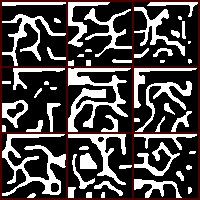

In [18]:
# show images generated at last iteration
for s in (samples[-1],):
    s = s * np.ones((1, 3, 1, 1))
    s = s.transpose((0, 2, 3, 1))
    img = dispims_color(s, border=2, bordercolor=(0.3, 0, 0), )
    imsave('out.png', img)
Image('out.png', width=400, height=400)

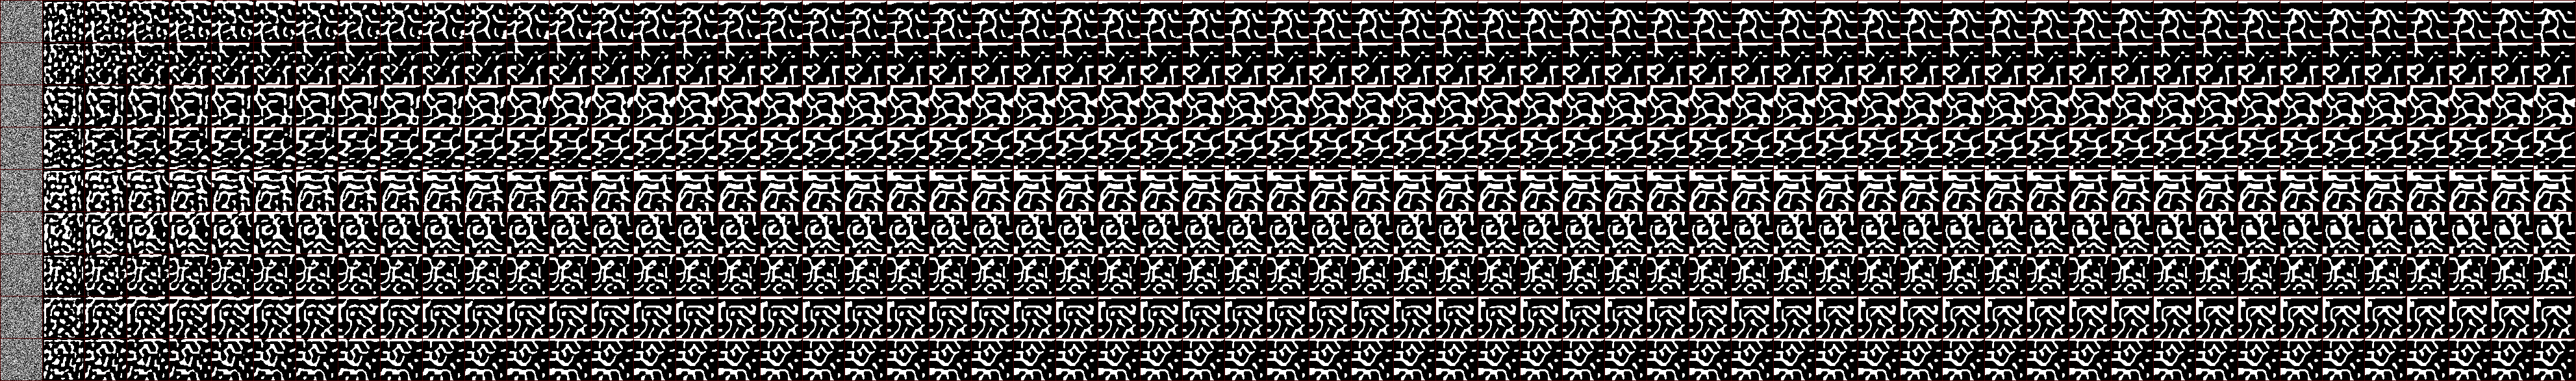

In [19]:
# sample samples and iterations
fig = plt.figure(figsize=(20, 20))
sw, sh = samples.shape[0:2]
samples_ = samples.copy()
samples_ = samples_.reshape((sw*sh, c, w, h))
samples_ = samples_.transpose((0, 2, 3, 1))
samples_ = samples_ * np.ones((1, 1, 1, 3))
img = dispims_color(samples_, shape=(sw, sh), border=1, bordercolor=(0.3,0,0))
imsave('out.png', img)
Image('out.png')

In [20]:
import os
from scripts.imgtovideo import imgs_to_video
from tools.brushstroke.common import embed_video
imgs = []
for s in samples:
    img = dispims_color(s.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)), border=2, bordercolor=(0.3, 0, 0))
    imgs.append(img)
if os.path.exists('out.mp4'):
    os.remove('out.mp4')
imgs_to_video(imgs, out='out.mp4', verbose=10, framerate=10, rate=10)
embed_video('out.mp4')

ffmpeg -framerate 10 -i img%08d.png -c:v libx264 -r 10 -pix_fmt yuv420p /home/mcherti/work/code/feature_generation/ipynb/out.mp4


## Video of the last row for brush stroke

In [ ]:
samples[-2].shape

In [ ]:
X = T.tensor4()
encode = theano.function(
    [X], 
    L.get_output(layers['brush'], X)
)

encode_coords = theano.function(
    [X],
    L.get_output(layers['coord'], X)
)

In [ ]:
bias = layers['bias'].b.get_value()

In [ ]:
X = capsule.preprocess(samples[-2][0:16*16])
xx = X.copy()
xx = xx.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
source = dispims_color(xx, border=0)

    
y = encode(X)

imgs = []
for t in range(y.shape[1]):
    yy = y[:, t]
    yy = yy[:, :, :, None] * np.ones((1, 1, 1, 3))
    yy = sigmoid(yy+bias) > 0.5
    yy = yy.astype(np.float32)
    img = dispims_color(yy, border=0) 
    plt.imshow(img)
    imgs.append(img)

seq_imgs = imgs

In [ ]:
imgs = [np.zeros_like(imgs[0])] + imgs
img_aggreg = np.zeros((img.shape[0], img.shape[1]*2, 3))
img_aggreg[0:source.shape[0], 0:source.shape[1]] = source
img_aggreg[:, source.shape[1]:source.shape[1]+img.shape[1]] = img
imsave('out.png', img_aggreg)

In [ ]:
import os
if os.path.exists('out.mp4'):
    os.remove('out.mp4')
imgs_to_video(imgs, out='out.mp4', verbose=1, framerate=8, rate=8)

## project into feature space

In [ ]:
hid = []
d = []
for i in range(10):
    X = data.X
    data.load()
    d.append(capsule.preprocess(X).transpose((0, 2 ,3 , 1))  * np.ones((1, 1, 1, 3)))
    C = encode(capsule.preprocess(X))
    if type(C) == list:
        C = [c.reshape(c.shape[0], -1) for c in C]
        #C = C[-1]
        C = np.concatenate(C, axis=1)        
    hid.append(C)
d = np.concatenate(d, axis=0)
hid = np.concatenate(hid, axis=0)
hid = hid.reshape((hid.shape[0], -1))
print(hid.shape)

In [ ]:
#mf = PCA(n_components=2)
mf = TSNE(n_components=2)
h2d = mf.fit_transform(hid)

In [ ]:
#mf = PCA(n_components=2)
mf = TSNE(n_components=2)
d2d = mf.fit_transform(d.reshape(d.shape[0], -1))

In [ ]:
from tools.viz.image_scatter import image_scatter
img = image_scatter(h2d, d, 20)
imsave('out_scatter.png', img)
Image('out_scatter.png')

In [ ]:
img = image_scatter(d2d, d, 20)
imsave('out_scatter_data.png', img)
Image('out_scatter_data.png')

## transferability

In [ ]:
X_transf_orig = external_data[0:100].copy()


im = X_transf_orig.copy().astype(np.float32)
imgs = []
for i in tqdm(range(100)):
    im = im + (capsule.reconstruct(im) - im)
    imgs.append(im.copy())
    
from scripts import imgtovideo
x = []
for img in imgs:
    img = img * np.ones((1, 3, 1, 1))
    img = img.transpose((0, 2, 3, 1))
    x.append(dispims_color(img))

In [ ]:
!rm out.mp4
imgs_to_video(x, out='out.mp4', verbose=1)

In [ ]:
embed_video('out.mp4')

## forced generation

In [ ]:
gen, discr = load_gan_model('/home/mcherti/work/code/lasagne-dcgan/fonts.pkl')

## rnn

In [ ]:
X = T.tensor4()
Xinit = X
nb_steps = 4
for i in range(nb_steps):
    X = L.get_output(layers['output'], X)
score = L.get_output(discr, X)
loss = (score).mean()
grad = theano.grad(loss, Xinit)
get_grad = theano.function([Xinit], grad)
get_loss = theano.function([Xinit], loss)
get_gen = theano.function([Xinit], X)

In [ ]:
import scipy
def eval_loss(x0):
    x0 = x0.reshape((nb, c, w, h))
    return -get_loss(x0.astype(np.float32)).astype('float64')

def eval_grad(x0):
    x0 = x0.reshape((nb, c, w, h))
    return get_grad(x0.astype(np.float32)).flatten().astype('float64')

In [ ]:
nb = 100
x = np.random.uniform(size=(nb, c, w, h))
x = x.astype(np.float32)
for i in range(40):
    #x, _, _ = scipy.optimize.fmin_l_bfgs_b(eval_loss, x.flatten(), fprime=eval_grad, maxfun=1)
    #x = x.reshape((nb, c, w, h)).astype(np.float32)
    x += 0.1 * get_grad(x)
    print(get_loss(x))

In [ ]:
img = get_gen(x) * np.ones((1, 3, 1, 1))
img = img.transpose((0, 2, 3, 1))
fig = plt.figure(figsize=(10, 10))
img = dispims_color(img, border=1, bordercolor=(10, 10, 10))
plt.imshow(img)

In [ ]:
from datakit.mnist import MNIST
data = MNIST('train')
data.load()
X_train = data.X.reshape((data.X.shape[0], 1, 28, 28))
y_train = data.y
def transform(X):
    h = []
    for i in range(0, X.shape[0], 128):
        C = encode(X[i:i + 128])
        hh = np.concatenate([cc.max(axis=(2, 3)).reshape((cc.shape[0], -1)) for cc in C], axis=1)      
        h.append(hh)
    h = np.concatenate(h, axis=0)
    return h

X_train = transform(X_train)

data = MNIST('test')
data.load()
X_test = data.X.reshape((data.X.shape[0], 1, 28, 28))
X_test = transform(X_test)
y_test = data.y

In [ ]:
Xrec = capsule.reconstruct(data.)

## VAE

In [ ]:
Z = T.matrix()
X = T.tensor4()
sample = theano.function([Z], L.get_output(layers['output'], {layers['z_sample']: Z}))

pred_z = theano.function([X], L.get_output(layers['z_mu'], X))

z_size = layers['z_sample'].output_shape[1]

In [ ]:
x = data.X[0:5000]
z = pred_z(capsule.preprocess(x))
fig = plt.figure(figsize=(20, 10))
cmap = plt.get_cmap('jet', 10)
cmap.set_under('gray')
r_inp = np.random.uniform(size=(100, w*h*c)).astype(np.float32)
r = pred_z(capsule.preprocess(r_inp))
plt.scatter(z[:, 0], z[:, 1])

In [ ]:
nb = 121
if z_size == 2:
    x = np.linspace(-1, 1, np.sqrt(nb))
    y = np.linspace(-1, 1, np.sqrt(nb))
    x, y = np.meshgrid(x, y)
    x = x.flatten()
    y = y.flatten()
    z_samples = np.vstack((x, y)).T
else:
    #z_samples = np.random.normal(0, 1, size=(nb, z_size))
    #z_samples[:, :]=0
    z_samples[:, 10]=np.linspace(-8, 8, len(z_samples))
z_samples = z_samples.astype(np.float32)
x_samples = sample(z_samples)

x_samples = x_samples.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3))
fig = plt.figure(figsize=(10, 10))
img = dispims_color(x_samples)
plt.imshow(img)

In [ ]:
imsave('out.png', img)
Image('out.png')

### GAN

In [ ]:
from skimage.transform import resize
import theano

In [ ]:
gen, discr = load_gan_model('../tools/mnist.pkl')

In [ ]:
X = T.tensor4()
discr_fn = theano.function([X], L.get_output(discr, X))

Z = T.matrix()
gen_fn = theano.function([Z], L.get_output(gen, Z))

In [ ]:
z_grad_fn = theano.function([X, Z], theano.grad( ((L.get_output(gen, Z)-X)**2).mean()  , Z))

In [ ]:
x_grad_n = theano.function([X], theano.grad(L.get_output(discr, X).mean(), X))

In [ ]:
def resize_set(x, w, h, **kw):
    x_out = np.empty((x.shape[0], 1, w, h))
    for i in range(len(x)):
        x_out[i, 0] = resize(x[i, 0], (w, h), **kw)
    return x_out.astype(np.float32)

In [ ]:
print(gen.output_shape)

In [ ]:
x = np.random.uniform(size=(9, 1, 28, 28)).astype(np.float32)
Z_of_X = np.random.uniform(-1, 1, size=(x.shape[0], 100)).astype(np.float32)


for i in range(20):
    #x += np.random.normal(0, 0.5, size=x.shape)
    x = capsule.reconstruct(x)
    x = x.astype(np.float32)
    x = resize_set(x, 32, 32)
    if True:
        z_rec = np.random.uniform(-1, 1, size=(x.shape[0], 100)).astype(np.float32)
        for _ in range(10):
            g = z_grad_fn(x, z_rec)
            z_rec -= 0.001*g
        
        gen = gen_fn(z_rec)
        gen =- gen.min(axis=0, keepdims=True)
        gen /= gen.max(axis=0, keepdims=True)
        x = x + (x - gen)
    if False:
        for _ in range(30):
            g = x_grad_n(x)
            x += 0.001*g
    x -= x.min(axis=(1, 2, 3), keepdims=True)
    x /= x.max(axis=(1, 2, 3), keepdims=True) 

    #x -= x.min(axis=0, keepdims=True)
    #x /= x.max(axis=0, keepdims=True) 

    x = resize_set(x, 28, 28, preserve_range=True)
    
    #x = x > 0.3
    x = x.astype(np.float32)

#x = resize_set(x, 32, 32)
print((discr_fn(x)).flatten().mean())

In [ ]:
img =  dispims_color(x.transpose((0, 2, 3, 1)) * np.ones((1, 1, 1, 3)))
imsave('out.png', img)
Image('out.png')

## fine tuning

In [ ]:
from lasagnekit.datasets.mnist import MNIST
data_train = MNIST(which='train')
data_train.load()
data_test = MNIST(which='test')
data_test.load()

In [ ]:
def preprocess_feats(f):
    f = map(lambda f_i:f_i.reshape((f_i.shape[0], -1)), f)
    f = np.concatenate(f, axis=1)
    return f
train_feats = list(get_feats(capsule.preprocess(data_train.X)))
train_feats.append(data_train.X)
train_feats = preprocess_feats(train_feats)
test_feats = list(get_feats(capsule.preprocess(data_test.X)))
test_feats.append(data_test.X)
test_feats = preprocess_feats(test_feats)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
clf = make_pipeline(PCA(n_components=1000), LogisticRegression())
#clf = LogisticRegression()
clf.fit(train_feats, data_train.y)

In [ ]:
(clf.predict(train_feats)==data_train.y).mean()

In [ ]:
(clf.predict(test_feats) == data_test.y).mean()